# Decomposed layer thickness gradients 

We split the layer thickness into two components: steady and unsteady. 

Steady corresponds to mean layer thickess and topographic effects, while the unsteady would correspond to the spatio-temporal variations that arise due to dynamics. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-07 00:14:52.300673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 00:14:52.300708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 00:14:52.302089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Experiment
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        #'dedx_middle_widened',
                                        #'dedy_middle_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 8*9 + 1, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

In [5]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'dedx_middle': ([], 1e-3),
    'dedy_middle': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),

    'dudx_nondim': ([], 1.),  # scalar value
    'dvdx_nondim': ([], 1.),
    'dudy_nondim': ([], 1.),
    'dvdy_nondim': ([], 1.),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),

    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dedx_middle_widened': ([], 1e-3),
    'dedy_middle_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [6]:
%%time
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'])

CPU times: user 3min 22s, sys: 1min 38s, total: 5min
Wall time: 4min 54s


In [7]:
ds = DT.simulation_data['DG']['100']

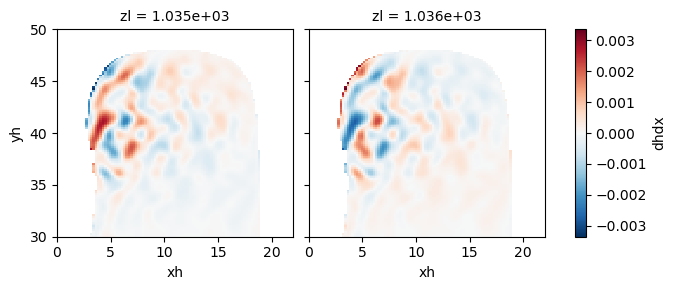

In [8]:
ds.dhdx.isel(Time=-1).plot(col='zl')

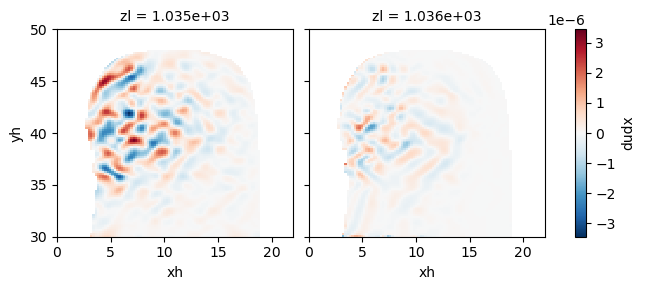

In [9]:
ds.dudx.isel(Time=-1).plot(col='zl')

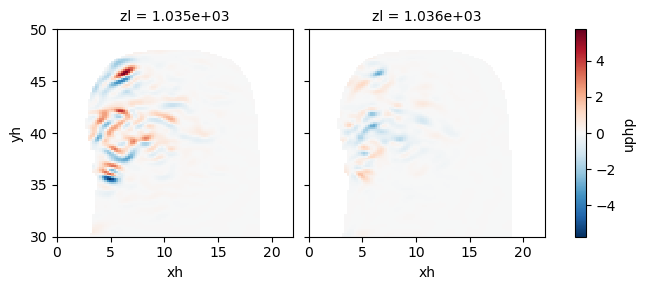

In [10]:
ds.uphp.isel(Time=-1).plot(col='zl')

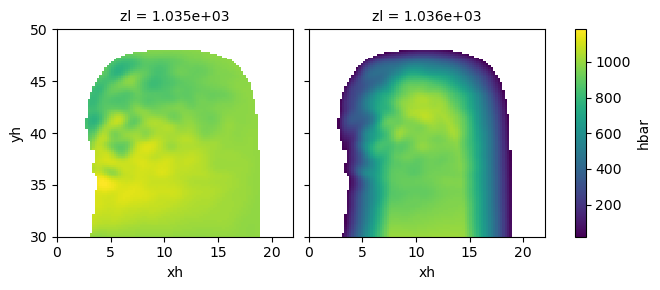

In [11]:
ds.hbar.isel(Time=-1).plot(col='zl')

In [12]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 1.733376 gb into memory.
load took: 17.6424 seconds
Will load : 0.1733376 gb into memory.
load took: 2.2560 seconds


In [13]:
batch_xr = ML_DT_train.ml_batches[0]

In [14]:
batch_xr.std()

<xarray.Dataset> Size: 64B
Dimensions:       ()
Data variables:
    dudx_widened  float64 8B 4.16e-07
    dvdx_widened  float64 8B 9.017e-07
    dudy_widened  float64 8B 6.336e-07
    dvdy_widened  float64 8B 4.165e-07
    dhdx_widened  float64 8B 0.0005493
    dhdy_widened  float64 8B 0.0005311
    filter_scale  float64 8B 1.341e+05
    uphp          float32 4B 0.4003
    vphp          float32 4B 0.6009

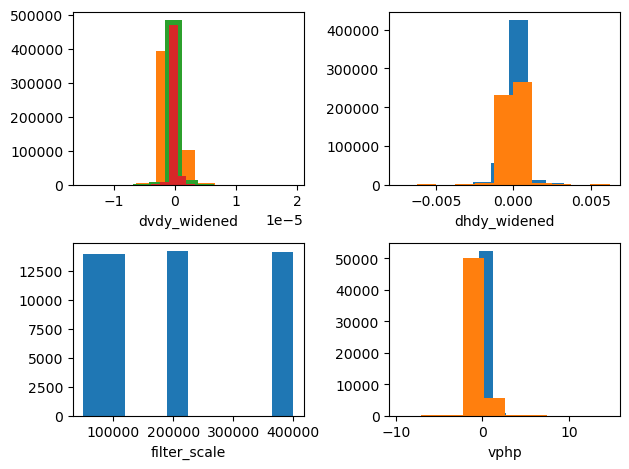

In [15]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [16]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [17]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (56192, 55)
Output (y) batch shape: (56192, 2)


In [18]:
num_in = batch_out['X'].shape[-1]
num_in

55

In [19]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [20]:
ANN_model.count_parameters()

3422


In [21]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [22]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 1. Train loss :  0.016555526570693868 , Test loss: 0.013222028315067292
At epoch 3. Train loss :  0.008300117065979017 , Test loss: 0.009792454354465008
At epoch 5. Train loss :  0.006635899126932428 , Test loss: 0.008077324181795121
At epoch 7. Train loss :  0.00555950789586515 , Test loss: 0.0068344431929290295
At epoch 9. Train loss :  0.004928577515120442 , Test loss: 0.006148265954107046
At epoch 11. Train loss :  0.004430849331657629 , Test loss: 0.0055833467282354835
At epoch 13. Train loss :  0.004032024383746289 , Test loss: 0.005095147900283337
At epoch 15. Train loss :  0.0037826257946624144 , Test loss: 0.004769851546734571
At epoch 17. Train loss :  0.0035602134287458015 , Test loss: 0.004500172659754753
At epoch 19. Train loss :  0.00331278214533184 , Test loss: 0.004230241011828184
At epoch 21. Train loss :  0.003187061507707915 , Test loss: 0.004065772797912359
At epoch 23. Train loss :  0.003094665618059603 , Test loss: 0.00394561979919672
At epoch 25. Train l

In [23]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [24]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])